## Quick start (<5 min) PBMCs tutorial

Set up datasets for the .Rmd tutorial.

In [1]:
# Basic function to plot cells, colored and faceted by metadata variables
# 
# metadata metadata, with UMAP labels in UMAP1 and UMAP2 slots
# title Plot title
# color.by metadata column name for phenotype labels
# facet.by metadata column name for faceting
# color.mapping custom color mapping
# show.legend Show cell type legend

plotBasic = function(umap_labels,                # metadata, with UMAP labels in UMAP1 and UMAP2 slots
                        title = 'Query',         # Plot title
                        color.by = 'cell_type',  # metadata column name for coloring
                        facet.by = NULL,         # (optional) metadata column name for faceting
                        color.mapping = NULL,    # custom color mapping
                        legend.position = 'right') {  # Show cell type legend
    
    p = umap_labels %>%
            dplyr::sample_frac(1L) %>% # permute rows randomly
            ggplot(aes(x = UMAP1, y = UMAP2)) + 
            geom_point_rast(aes(col = get(color.by)), size = 1, stroke = 0.4, shape = 16)
        if (!is.null(color.mapping)) { p = p + scale_color_manual(values = color.mapping) }
    
    # Default formatting
    p = p + theme_bw() +
            labs(title = title, color = color.by) + 
            theme(plot.title = element_text(hjust = 0.5)) +
            theme(legend.position=legend.position) +
            theme(legend.text = element_text(size=8), legend.title=element_text(size=12)) + 
            guides(colour = guide_legend(override.aes = list(size = 4))) + guides(alpha = 'none')

    if(!is.null(facet.by)) {
        p = p + facet_wrap(~get(facet.by)) +
                theme(strip.text.x = element_text(size = 12)) }    
    return(p)
}

# Colors for PBMCs
pbmc_colors = c("B" = "#66C2A5", 
              "DC" = "#FC8D62",
              "HSC" = "#8DA0CB",
              "MK" = "#E78AC3", 
              "Mono_CD14" = "#A6D854",
              "Mono_CD16" = "#f2ec72",
              "NK" = "#62AAEA", 
              "T_CD4" = "#D1C656",
              "T_CD8" = "#968763")

In [2]:
suppressPackageStartupMessages({
    # Analysis
    library(symphony)
    library(harmony)
    library(irlba)
    library(data.table)
    library(dplyr)

    # Plotting
    library(ggthemes)
    library(ggrastr)
    library(RColorBrewer)
    library(patchwork)
})

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}
fig.size(4, 6)

In [3]:
# Read in normalized expression and metadata
pbmcs_exprs_norm = readRDS('../../symphony_reproducibility/data/Fig2_pbmcs/exprs_norm_gold_filtered.rds')
pbmcs_meta = readRDS('../../symphony_reproducibility/data/Fig2_pbmcs/metadata_gold_filtered.rds')

pbmcs_meta$pub_res0.8 = NULL
pbmcs_meta$nnk5_res0.8 = NULL
pbmcs_meta$pub_cell_type = NULL
pbmcs_meta$pub_cell_subtype = NULL

dim(pbmcs_exprs_norm)
dim(pbmcs_meta)

[1] 33694 20571

[1] 20571     7

In [4]:
# Downsample the data
set.seed(0)
downsample_idx = sample(1:20571, 1200)
pbmcs_exprs_small = pbmcs_exprs_norm[, downsample_idx]
pbmcs_meta_small = pbmcs_meta[downsample_idx, ]

In [5]:
table(pbmcs_meta_small$donor)


3pv1 3pv2   5p 
 290  480  430 

## Get the data
If you would like to follow along, we provide the files `pbmcs_exprs_norm.rda` and `pbmcs_meta.rda` in the `data` directory.

In [6]:
dim(pbmcs_exprs_small)
dim(pbmcs_meta_small)

[1] 33694  1200

[1] 1200    7

In [7]:
pbmcs_meta_small %>% head(4)

,cell_id,donor,nUMI,nGene,percent_mito,cell_type,cell_type_broad
,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>
17642,fivePrime_GATCGCGAGACCGGAT,5p,6580,2020,0.05714286,B,B
4820,threepfresh_GATCGTACAAAGGTGC,3pv2,4426,1207,0.03366471,T_CD8,T
13347,fivePrime_AACTCAGGTTACGCGC,5p,4750,1670,0.05642105,B,B
10634,threepv1_CGTGATGAGTCCTC,3pv1,4121,1228,0.01504489,T_CD4,T


Subset dataset into reference and query

In [8]:
idx_query = which(pbmcs_meta_small$donor == "5p") # use 5' dataset as the query
ref_exp_full = pbmcs_exprs_small[, -idx_query]
ref_metadata = pbmcs_meta_small[-idx_query, ]
query_exp = pbmcs_exprs_small[, idx_query]
query_metadata = pbmcs_meta_small[idx_query, ]

# Build Symphony Reference

There are two options for how to build a Symphony reference. Option 1 (`buildReferenceFromHarmonyObj`) is the more modular option, meaning that the user has more control over the preprocessing steps prior to reference compression. Option 2 (`buildReference`) builds a reference starting from expression, automating the procedure more but offering less flexibility. 

We'll demonstrate both options below.

## Option 1: Build from Harmony object (preferred method)
This option consists of more steps than Option 2 but allows your code to be more modular and flexible if you want to do your own preprocessing steps before the Harmony integration step. We recommend this option for most users.

It is important to generate `vargenes_means_sds` (containing variable gene means and standard deviations used to scale the genes) as well as save the loadings for the PCA step. 

In [9]:
# Sparse matrix with the normalized genes x cells matrix
ref_exp_full[1:5, 1:2]

5 x 2 sparse Matrix of class "dgCMatrix"
             threepfresh_GATCGTACAAAGGTGC threepv1_CGTGATGAGTCCTC
RP11-34P13.3                            .                       .
FAM138A                                 .                       .
OR4F5                                   .                       .
RP11-34P13.7                            .                       .
RP11-34P13.8                            .                       .

Select variable genes and subset reference expression by variable genes

In [10]:
var_genes = vargenes_vst(ref_exp_full, groups = as.character(ref_metadata[['donor']]), topn = 1000)
ref_exp = ref_exp_full[var_genes, ]
dim(ref_exp)

[1] 1767  770

In [43]:
pbmcs_exprs_small = pbmcs_exprs_small[var_genes, ]
usethis::use_data(pbmcs_exprs_small, pbmcs_meta_small)

✔ Saving 'pbmcs_exprs_small', 'pbmcs_meta_small' to 'data/pbmcs_exprs_small.rda', 'data/pbmcs_meta_small.rda'

• Document your data (see 'https://r-pkgs.org/data.html')



Calculate and save the mean and standard deviations for each gene

In [11]:
vargenes_means_sds = tibble(symbol = var_genes, mean = Matrix::rowMeans(ref_exp))
vargenes_means_sds$stddev = rowSDs(ref_exp, vargenes_means_sds$mean)
head(vargenes_means_sds)

ERROR: Error in rowSDs(ref_exp, vargenes_means_sds$mean): could not find function "rowSDs"


Scale data using calculated gene means and standard deviations

In [12]:
ref_exp_scaled = scaleDataWithStats(ref_exp, vargenes_means_sds$mean, vargenes_means_sds$stddev, 1)

ERROR: Error in scaleDataWithStats(ref_exp, vargenes_means_sds$mean, vargenes_means_sds$stddev, : could not find function "scaleDataWithStats"


Run SVD, save gene loadings (s$u)

In [46]:
set.seed(0)
s = irlba(ref_exp_scaled, nv = 20)
Z_pca_ref = diag(s$d) %*% t(s$v) # [pcs by cells]
loadings = s$u

Run Harmony integration

In [47]:
set.seed(0)
ref_harmObj = harmony::HarmonyMatrix(
        data_mat = t(Z_pca_ref),  ## PCA embedding matrix of cells
        meta_data = ref_metadata, ## dataframe with cell labels
        theta = c(2),             ## cluster diversity enforcement
        vars_use = c('donor'),    ## variable to integrate out
        nclust = 100,             ## number of clusters in Harmony model
        max.iter.harmony = 20,
        return_object = TRUE,     ## return the full Harmony model object
        do_pca = FALSE            ## don't recompute PCs
)

Harmony 1/20

Harmony 2/20

Harmony 3/20

Harmony 4/20

Harmony 5/20

Harmony converged after 5 iterations



To run the next function `buildReferenceFromHarmonyObj()`, you need to input the saved gene loadings (`loadings`) and `vargenes_means_sds`.

In [48]:
# Compress a Harmony object into a Symphony reference
reference = symphony::buildReferenceFromHarmonyObj(
                           ref_harmObj,            # output object from HarmonyMatrix()
                           ref_metadata,           # reference cell metadata
                           vargenes_means_sds,     # gene names, means, and std devs for scaling
                           loadings,               # genes x PCs matrix
                           verbose = TRUE,         # verbose output
                           do_umap = TRUE,         # Set to TRUE only when UMAP model was saved for reference
                           save_uwot_path = './testing_uwot_model_1')

Save metadata, vargenes (S), and loadings (U)

Save R, Z_orig, Z_corr, and betas from Harmony object

Calculate final L2 normalized reference centroids (Y_cos)

Calculate reference compression terms (Nr and C)

UMAP

File already exists at that path... overwriting...

Warning message:
“invalid uid value replaced by that for user 'nobody'”
Saved uwot model

Finished nicely.



Save Symphony reference (modify with your desired output path)

In [49]:
saveRDS(reference, './testing_reference1.rds')

Let's take a look at what the reference object contains:
- meta_data: metadata
- vargenes: variable genes, means, and standard deviations used for scaling
- loadings: gene loadings for projection into pre-Harmony PC space
- R: Soft cluster assignments
- Z_orig: Pre-Harmony PC embedding
- Z_corr: Harmonized PC embedding
- centroids: locations of final Harmony soft cluster centroids
- cache: pre-calculated reference-dependent portions of the mixture model
- umap: UMAP coordinates
- save_uwot_path: path to saved uwot model (for query UMAP projection into reference UMAP coordinates)

In [50]:
str(reference)

List of 12
 $ meta_data     :'data.frame':	770 obs. of  7 variables:
  ..$ cell_id        : chr [1:770] "threepfresh_GATCGTACAAAGGTGC" "threepv1_CGTGATGAGTCCTC" "threepv1_AAGAATCTTGGAGG" "threepfresh_CTGAAACCACACTGCG" ...
  ..$ donor          : chr [1:770] "3pv2" "3pv1" "3pv1" "3pv2" ...
  ..$ nUMI           : int [1:770] 4426 4121 1535 11956 6273 1840 2702 4260 3436 3966 ...
  ..$ nGene          : int [1:770] 1207 1228 560 2685 1615 584 945 1188 1360 1486 ...
  ..$ percent_mito   : num [1:770] 0.0337 0.015 0.0261 0.0278 0.0289 ...
  ..$ cell_type      : chr [1:770] "T_CD8" "T_CD4" "B" "DC" ...
  ..$ cell_type_broad: chr [1:770] "T" "T" "B" "DC" ...
 $ vargenes      : tibble [1,767 × 3] (S3: tbl_df/tbl/data.frame)
  ..$ symbol: chr [1:1767] "LYZ" "FTL" "HLA-DRA" "CD74" ...
  ..$ mean  : Named num [1:1767] 1.78 3.55 1.87 2.54 2.53 ...
  .. ..- attr(*, "names")= chr [1:1767] "LYZ" "FTL" "HLA-DRA" "CD74" ...
  ..$ stddev: Named num [1:1767] 1.91 1.22 1.69 1.53 1.46 ...
  .. ..- attr(*, "n

The harmonized embedding is located in the `Z_corr` slot of the reference object.

In [51]:
dim(reference$Z_corr)
reference$Z_corr[1:5, 1:5]

[1]  20 770

,4820,10634,8538,4091,11682
harmony_1,-5.86582910,-5.2391890,-3.9160812,9.5522895,14.48509568
harmony_2,0.63532030,1.2168169,-14.0733634,-2.3384053,0.54561273
harmony_3,4.18582875,3.8074352,-5.9540371,-0.1056305,0.07950463
harmony_4,-0.91237369,-0.5037637,0.1755544,-0.4632790,-3.82706116
harmony_5,0.05553176,1.5168596,-1.0497742,5.4897877,3.72461112


Visualize reference UMAP

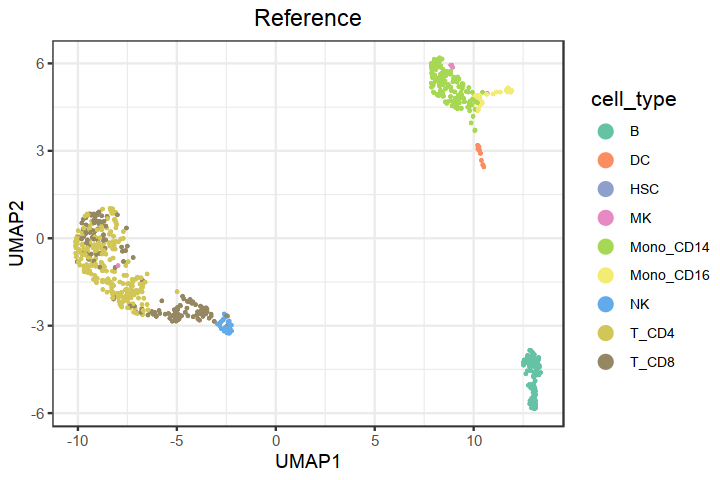

In [52]:
reference = readRDS('./testing_reference1.rds')

umap_labels = cbind(ref_metadata, reference$umap$embedding)

plotBasic(umap_labels, title = 'Reference', color.mapping = pbmc_colors)

## Option 2: Build from scratch (starting with expression)

This option computes a reference object starting from expression in a unified pipeline, automating the preprocessing steps.

In [53]:
# Build reference
set.seed(0)
reference = symphony::buildReference(
    ref_exp_full,
    ref_metadata,
    vars = c('donor'),         # variables to integrate over
    K = 100,                   # number of Harmony clusters
    verbose = TRUE,            # verbose output
    do_umap = TRUE,            # can set to FALSE if want to run umap separately later
    do_normalize = FALSE,      # set to TRUE if input counts are not normalized yet
    vargenes_method = 'vst',   # method for variable gene selection ('vst' or 'mvp')
    vargenes_groups = 'donor', # metadata column specifying groups for variable gene selection 
    topn = 1000,               # number of variable genes to choose per group
    d = 20,                    # number of PCs
    save_uwot_path = './testing_uwot_model_2'
)

# Save reference (modify with your desired output path)
saveRDS(reference, './testing_reference2.rds')

Finding variable genes using vst method

Total 1767 genes for downstream steps

Scaling and PCA

Running Harmony integration

Harmony 1/20

Harmony 2/20

Harmony 3/20

Harmony 4/20

Harmony 5/20

Harmony 6/20

Harmony 7/20

Harmony converged after 7 iterations

Computing reference compression terms

Running UMAP

File already exists at that path... overwriting...

Warning message:
“invalid uid value replaced by that for user 'nobody'”
Saved uwot model



Visualize reference UMAP

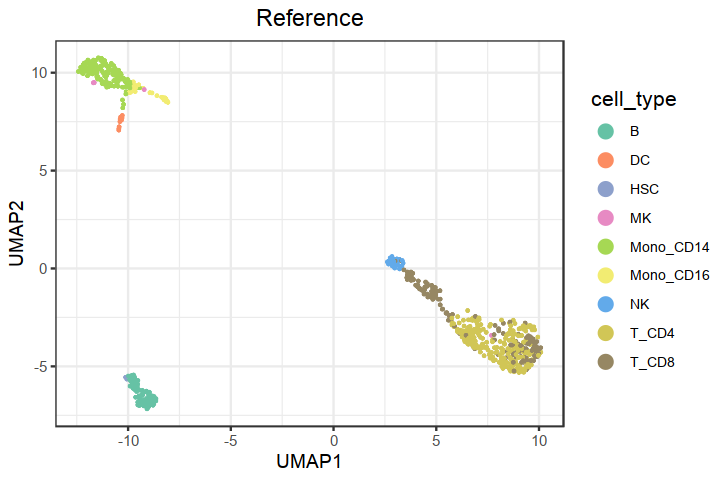

In [54]:
reference = readRDS('./testing_reference2.rds')

umap_labels = cbind(ref_metadata, reference$umap$embedding)

plotBasic(umap_labels, title = 'Reference', color.mapping = pbmc_colors)

# Map query

In order to map a new query dataset onto the reference, you will need a reference object saved from the steps above, as well as query cell expression and metadata.

The query dataset is assumed to have been normalized in the same manner as the reference cells (here, default is log(CP10k+1) normalization).

In [55]:
# Read in Symphony reference to map to
reference = readRDS('./testing_reference1.rds')

In [56]:
# Map query
query = mapQuery(query_exp,             # query gene expression (genes x cells)
                 query_metadata,        # query metadata (cells x attributes)
                 reference,             # Symphony reference object
                 do_normalize = FALSE,  # perform log(CP10k) normalization on query
                 do_umap = TRUE)        # project query cells into reference UMAP

Scaling and synchronizing query gene expression

Found 1767 out of 1767 reference variable genes in query dataset

Project query cells using reference gene loadings

Clustering query cells to reference centroids

Correcting query batch effects

UMAP

All done!



Note: Symphony assumes that the query is normalized in the same manner as the reference. Our implementation currently uses log(CP10k) normalization.

Let's take a look at what the query object contains:
- Z: query cells in reference Harmonized embedding
- Zq_pca: query cells in pre-Harmony reference PC embedding (prior to correction)
- R: query cell soft cluster assignments
- Xq: query cell design matrix for correction step
- umap: query cells projected into reference UMAP coordinates (using uwot)
- meta_data: metadata

In [57]:
str(query)

List of 7
 $ exp      :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:772050] 8 73 85 97 101 139 153 173 176 188 ...
  .. ..@ p       : int [1:431] 0 2020 3690 5358 7385 9275 10663 12324 14129 15546 ...
  .. ..@ Dim     : int [1:2] 33694 430
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:33694] "RP11-34P13.3" "FAM138A" "OR4F5" "RP11-34P13.7" ...
  .. .. ..$ : chr [1:430] "fivePrime_GATCGCGAGACCGGAT" "fivePrime_AACTCAGGTTACGCGC" "fivePrime_ACATCAGGTCTTGTCC" "fivePrime_GCCTCTATCATGTCCC" ...
  .. ..@ x       : num [1:772050] 0.924 0.924 0.924 0.924 1.396 ...
  .. ..@ factors : list()
 $ meta_data:'data.frame':	430 obs. of  7 variables:
  ..$ cell_id        : chr [1:430] "fivePrime_GATCGCGAGACCGGAT" "fivePrime_AACTCAGGTTACGCGC" "fivePrime_ACATCAGGTCTTGTCC" "fivePrime_GCCTCTATCATGTCCC" ...
  ..$ donor          : chr [1:430] "5p" "5p" "5p" "5p" ...
  ..$ nUMI           : int [1:430] 6580 4750 4432 5831 5558 5360 4749 5152 4929 4194 ...
  ..$ nGene       

Predict query cell types using k-NN

In [58]:
query = knnPredict(query, reference, reference$meta_data$cell_type, k = 5)

Query cell type predictions are now in the `cell_type_pred_knn` column.

In [59]:
head(query$meta_data)

,cell_id,donor,nUMI,nGene,percent_mito,cell_type,cell_type_broad,cell_type_pred_knn
,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<fct>
17642,fivePrime_GATCGCGAGACCGGAT,5p,6580,2020,0.05714286,B,B,B
13347,fivePrime_AACTCAGGTTACGCGC,5p,4750,1670,0.05642105,B,B,B
13638,fivePrime_ACATCAGGTCTTGTCC,5p,4432,1668,0.03993682,B,B,B
17934,fivePrime_GCCTCTATCATGTCCC,5p,5831,2027,0.03258446,T_CD4,T,T_CD4
14432,fivePrime_AGGGATGGTGGGTATG,5p,5558,1890,0.05865419,B,B,B
18442,fivePrime_GGGACCTCATGCCACG,5p,5360,1388,0.03750000,T_CD4,T,T_CD4


## Visualization of mapping

In [60]:
# Sync the column names for both data frames
reference$meta_data$cell_type_pred_knn = NA
reference$meta_data$ref_query = 'reference'
query$meta_data$ref_query = 'query'

# Add the UMAP coordinates to the metadata
meta_data_combined = rbind(query$meta_data, reference$meta_data)
umap_combined = rbind(query$umap, reference$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined)

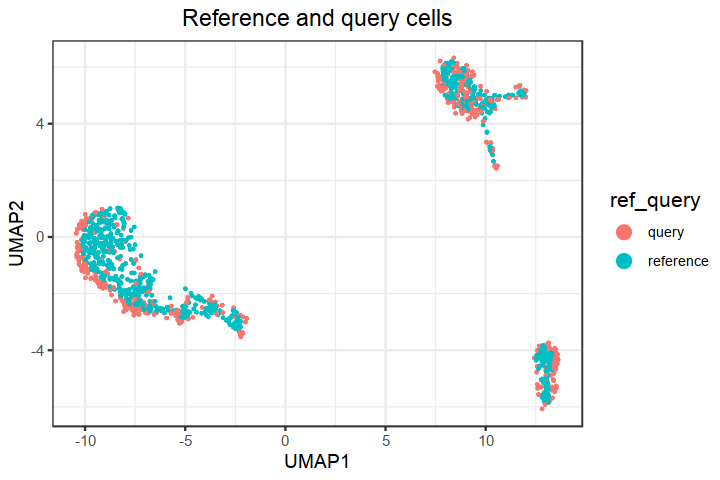

In [61]:
# Plot UMAP visualization of all cells

plotBasic(umap_combined_labels, title = 'Reference and query cells', color.by = 'ref_query')

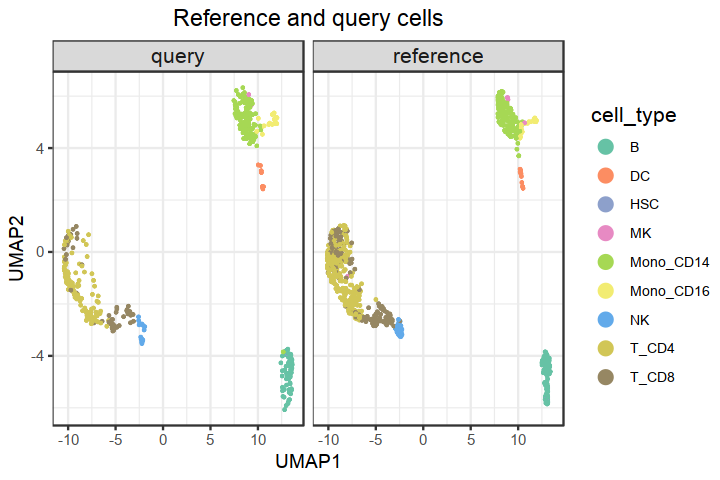

In [62]:
plotBasic(umap_combined_labels, title = 'Reference and query cells', 
          color.mapping = pbmc_colors, facet.by = 'ref_query')

In [63]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/seurat4/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] patchwork_1.1.1    RColorBrewer_1.1-2 ggrastr_0.2.3      ggthemes_4.2.4    
 [5] data.table_1.14.0  forcats_0.5.1      stringr_1.4.0      dplyr_1.0.7       
 [9] purrr_0.3.4        readr_1.4.0        tidyr_1.1.3        tibble_3.1.2      
[13] ggplot2_3.3.5     

And that's a wrap! If you run into issues or have questions about Symphony or this tutorial, please open an issue on GitHub.